# Anomaly Detection Excercise

by Stijn Geselle

In [42]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import random
from itertools import cycle

Parse the data from the input file. The input is a CSV with 2D points.

In [28]:
data = np.genfromtxt('data/anomaly.csv', delimiter=',')

Make a scatter plot of the data to get a sense of what we are dealing with.

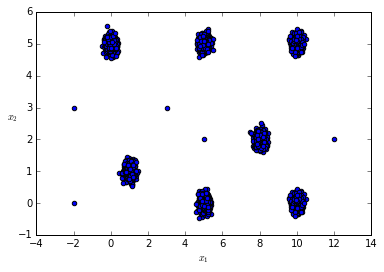

In [43]:
plt.scatter(data[:,0], data[:,1])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$', rotation=0)
plt.show()

We can distinguish seven clusters so we need to create a boundary around those clusters. All data points that are located outside the cluster's boundary will be flagged as an anomaly.

In [50]:
# Number of clusters we have
nclusters = 7

The main idea is to first find the clusters by using $k$-means and then calculate the median distance from each point of the cluster to the cluster's center. Points that are far away from the center will be flagged as outliers. We will use the standard deviation to determine if a distance is far away from the center. The median is used instead of the mean, because outliers have a high impact on a mean.

## $k$-means algorithm to find the clusters

In [51]:
def kmeans(X, k):
    # Initialize to k random centers
    oldmu = random.sample(X, k)
    mu = random.sample(X, k)
    
    # Converges when the mu and oldmu values are the same
    while not is_equal(mu, oldmu):
        oldmu = mu
        # Assign all points in X to clusters
        clusters = cluster_data(X, mu)
        # Reevaluate centers
        mu = reevaluate_centroids(clusters)
        
    return (mu, clusters)

def cluster_data(X, mu):
    clusters  = {}
    
    for x in X:
        norms = []
        
        # Iterate over all centroids and find the one with the minimum norm
        for centroid in enumerate(mu):
            norm = np.linalg.norm(x-mu[centroid[0]])
            norms.append( (centroid[0], norm) )
            
        bestcluster = min(norms, key=lambda t: t[1])[0]
        
        if bestcluster in clusters:
            clusters[bestcluster].append(x)
        else:
            clusters[bestcluster] = [x]
            
    return clusters

def is_equal(mu, oldmu):
    
    # We use a set here to make comparison easier
    return (set([tuple(a) for a in mu]) == set([tuple(a) for a in oldmu]))

def reevaluate_centroids(clusters):
    # Calculate the new mean (mu) of each cluster
    mu = [np.mean(clusters[k], axis=0) for k in sorted(clusters.keys())]
        
    return mu

## Outlier detection of the clusters

In [52]:
def euclidian_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))


def outliers(clusters, centroids, nsigma=3):
    outliers = []
    
    for label, cluster in clusters.iteritems():
        center = centroids[label]
    
        # Calculate the Euclidian distances from each point to the center of the cluster
        distances_center = {euclidian_distance(x, center): x for x in cluster}
        median = np.median(distances_center.keys())    
        sigma = np.std(distances_center.keys())  
        
        # An outlier is a point thats nsigma away from the median of the Euclidian distances
        # We use the median instead of the mean, because outliers have high impact on the mean
        cluster_outliers = [point for dist,point in distances_center.iteritems()
                            if dist > median+nsigma*sigma or dist < median-nsigma*sigma]
        
        outliers.extend(cluster_outliers)
        
    return outliers

Lets find the clusters and the outliers now:

In [53]:
centroids, clusters = kmeans(data, nclusters)
anomalies = outliers(clusters, centroids, nsigma=4)

print anomalies

[array([-2.,  3.]), array([ 3.,  3.]), array([-2.,  0.]), array([ 5.,  2.]), array([ 12.,   2.]), array([-0.18515,  5.5484 ])]


## Plot of the anomalies

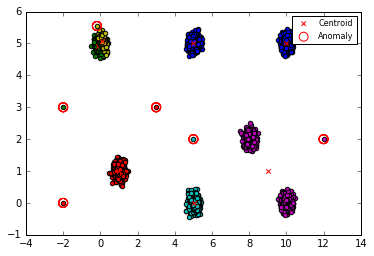

In [54]:
colors = cycle('bgrcmy')
    
for label, cluster in clusters.iteritems():
    cluster = np.array(cluster)
    # Plot the points of the cluster
    d = plt.scatter(cluster[:,0], cluster[:,1], c=colors.next())
    # Plot the center of the cluster
    c = plt.scatter(centroids[label][0], centroids[label][1], c='r', marker='x')
    # Plot the anomalies
    anomalies = np.array(anomalies)        
    a= plt.scatter(anomalies[:,0], anomalies[:,1], marker='o', s=80, facecolors='none', edgecolors='r')


plt.legend((c, a), ('Centroid', 'Anomaly'), scatterpoints=1, loc='best', fontsize=8)
plt.show()

## Remarks

The problem with $k$-means is that the results can differ from each run because the initial centers are chosen randomly and the outliers have an impact on the computed center. A possible improvement is to run $k$-means a few times and remove the temporarly found outliers from the data. Then the centers will be more accurate and the result more stable.